## Reading in data available through The Arabidopsis Information Resource (TAIR) database
The purpose of this notebook is to read in and do a preliminary survey of the data related to text and ontology annotations of text that is available through TAIR. The datasets need to be organized and also restructured into a standard format that will allow it be combined with datasets from other resources.

In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys
import os
import warnings
import pandas as pd
import numpy as np
import itertools
import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

sys.path.append("../../oats")
from oats.utils.constants import NCBI_TAG
from oats.utils.constants import EVIDENCE_CODES
from oats.utils.utils import to_abbreviation
from oats.nlp.preprocess import concatenate_with_bar_delim
from oats.nlp.preprocess import other_delim_to_bar_delim
from oats.nlp.preprocess import remove_punctuation
from oats.nlp.preprocess import remove_enclosing_brackets
from oats.nlp.preprocess import concatenate_descriptions
from oats.nlp.preprocess import add_prefix

OUTPUT_DIR = "../data/reshaped_files"
mpl.rcParams["figure.dpi"] = 200
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Part 1: Phenotypic Text Data
Reading in the dataset of phenotypic descriptions. There is only one value specified as the gene name (locus name) in the original dataset so this column does not need to be parsed further. The descriptions commmonly use semi-colons to separate phrases. The next cell gets the distribution of the number of phrases in each description field for the dataset of text descriptions, as determined by a sentence parser. The majority of the descriptions are a single sentence or phrase, but some contain more.

In [38]:
filename = "../data/gene_related_files/tair/Locus_Germplasm_Phenotype_20180702.txt"
usecols = ["LOCUS_NAME", "PHENOTYPE", "PUBMED_ID"]
usenames = ["gene_names", "description", "pmid"]
renamed = {k:v for k,v in zip(usecols,usenames)}
df = pd.read_table(filename, usecols=usecols)
df.rename(columns=renamed, inplace=True)
df.sample(20)

,gene_names,description,pmid
6813,AT3G49240,embryo lethal.,28760958.0
12111,AT5G66750,Phenotype not described.,10319870.0
1915,AT1G50500,Hypersensitive to heat and osmotic stress.,NaN
7649,AT4G01800,Chloroplasts are smaller than wild type. lack ...,20194926.0
9091,AT4G36380,Flowers are smaller and develop one week later...,17138693.0
9733,AT5G09830,No visible phenotype,NaN
12796,EMB1673,embryo defective; terminal embryo phenotype: p...,NaN
13353,EMB2465,embryo defective; terminal embryo phenotype: g...,NaN
4993,AT2G42700,abnormally accumulated storage protein precurs...,24118572.0
10362,AT5G20730,"In the presence of 1 microM brassinazole, an i...",16632588.0


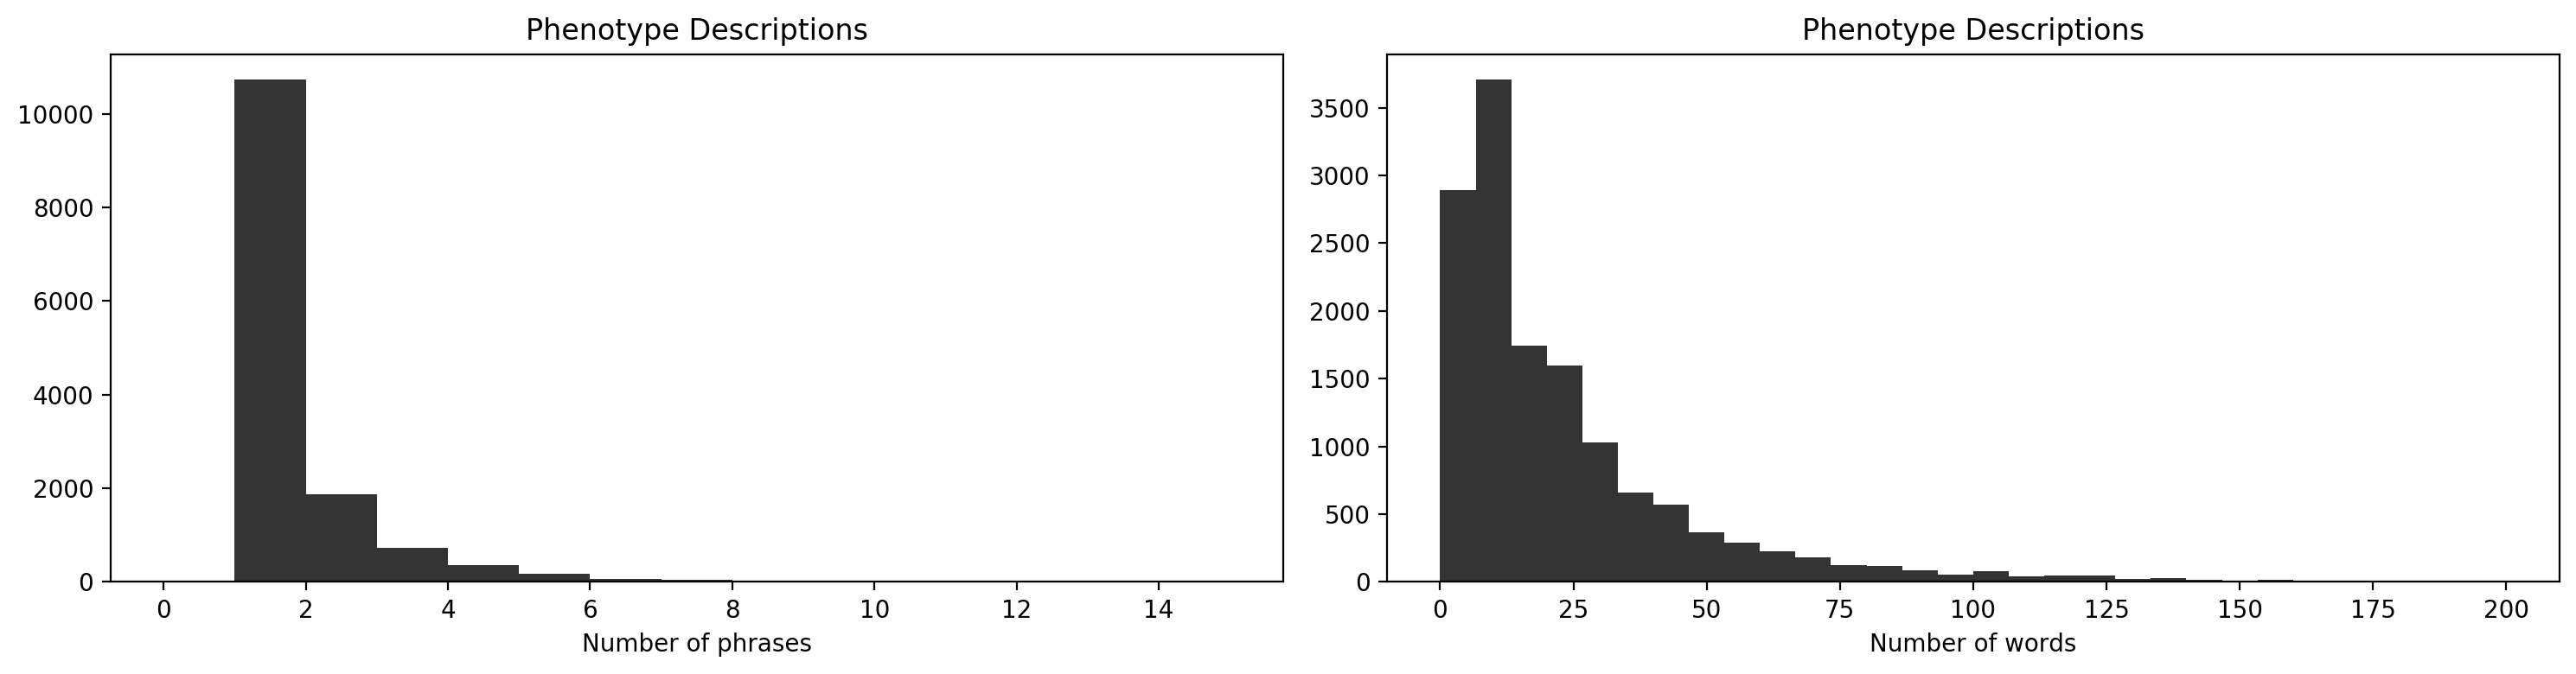

In [39]:
# Plotting distributions of number of phrases in each description.
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Phenotype Descriptions")
ax2.set_title("Phenotype Descriptions")
ax1.set_xlabel("Number of phrases")
ax2.set_xlabel("Number of words")
x1 = [len(sent_tokenize(x)) for x in df["description"].values]
x2 = [len(word_tokenize(x)) for x in df["description"].values]
ax1.hist(x1, bins=15, range=(0,15), density=False, alpha=0.8, histtype='stepfilled', color="black", edgecolor='none')
ax2.hist(x2, bins=30, range=(0,200), density=False, alpha=0.8, histtype='stepfilled', color="black", edgecolor='none')
fig.set_size_inches(15,4)
fig.tight_layout()
fig.show()

In [40]:
# Restructuring the dataset to include all expected column names.
df["species"] = "ath"
df["term_ids"] = ""

# Outputting the dataset of phenotype descriptions to csv file.
path = os.path.join(OUTPUT_DIR,"ath_phenotypes.csv")
df.to_csv(path, index=False)

### Part 2.1: Gene Ontology Term Annotations
Read in the file containing names of loci and corresponding information relating to gene ontology term annotation. Not all of the columns are used here, only a subset of them are read in. The relationship column refers to the relationships between the gene for that loci and the term mentioned on that given line. Evidence refer to the method of acquiring and the confidence in the annotation itself. This is retained so that we can subset that dataset based on whether the annotations are experimentally confirmed or simply predicted annotations. This section also looks at how many unique values are present for each field.

Each term annotation in this dataset is also associated with an evidence code specifying the method by which this annotation was made, which is related to the confidence that we can have in this annotation, and the tasks that the annotation should be used for. About half of the term annotations were made computationally, but there are also a high number of annotations available from high confidence annotations such as experimentally validated, curator statements, and author statements.

In [41]:
filename = "../data/gene_related_files/tair/ATH_GO_GOSLIM.txt"
df_go = pd.read_table(filename, header=None, usecols=[0,3,4,5,9,12])
df_go.columns = ["locus","relationship","term_label","term_id","evidence_code","reference"]
unique_values = {col:len(pd.unique(df_go[col].values)) for col in df_go.columns}
print(df_go[["locus","term_id","evidence_code","reference"]].head(10))
print(df_go.shape)
for k,v in unique_values.items():
    print("{:18}{:8}".format(k,v))

       locus     term_id evidence_code                    reference
0  AT1G01010  GO:0007275           ISS      Communication:501714663
1  AT1G01010  GO:0005634           ISM  AnalysisReference:501750651
2  AT1G01010  GO:0003700           ISS          Publication:1345963
3  AT1G01010  GO:0043090           RCA        Publication:501748728
4  AT1G01010  GO:0006888           RCA        Publication:501748728
5  AT1G01020  GO:0006665           IMP        Publication:501719026
6  AT1G01020  GO:0016125           IMP        Publication:501719026
7  AT1G01020  GO:0005783           IDA        Publication:501719026
8  AT1G01020  GO:0016020           ISS      Communication:501714663
9  AT1G01020  GO:0005739           ISM  AnalysisReference:501750651
(251297, 6)
locus                30251
relationship            19
term_label            4924
term_id               4924
evidence_code           13
reference             9149


In [42]:
code_quantities = {c:len([x for x in df_go["evidence_code"] if EVIDENCE_CODES[x] in c]) 
             for c in list(set(EVIDENCE_CODES.values()))}
for k,v in code_quantities.items():
    print("{:25}{:8}".format(k,v))

experimental                85701
author_statement            13460
computational              125915
high_throughput                 0
curator_statement           24550
phylogenetics                1671
electronic_annotation           0


In [43]:
# Restructuring the dataset to include all the expected column names.
df_go["species"] = "ath"
df_go["gene_names"] = df_go["locus"]
df_go["description"] = ""
df_go["term_ids"] = df_go["term_id"]
df_go["pmid"] = df_go["reference"]
high_confidence_categories = ["experimental","other_statement","curator_statement"]
df_go["high_confidence"] = df_go["evidence_code"].apply(lambda x: EVIDENCE_CODES[x] in high_confidence_categories)

# Subset to only include the high-quality GO annotations and ouptut the dataset to a csv file.
df_go_high_confidence = df_go[df_go["high_confidence"]==True]
path = os.path.join(OUTPUT_DIR,"ath_high_confidence_go_annotations.csv")
df_go_high_confidence = df_go_high_confidence[["species", "gene_names", "description", "term_ids", "pmid"]]
df_go_high_confidence.to_csv(path, index=False)

# Outputting the dataset of annotations to a csv file.
df_go = df_go[["species", "gene_names", "description", "term_ids", "pmid"]]
path = os.path.join(OUTPUT_DIR,"ath_all_go_annotations.csv")
df_go.to_csv(path, index=False)

### Part 2.2: Plant Ontology Term Annotations
There are two separate files available that include annotations of PO terms. The files do not have headers so column names are added based on how the columns are described in the accompanying available readme files. One of the files contains annotations for PO terms that are spatial, or describe a specific part of plant anatomy or plant molecular structures. The other file contains annotations for PO terms that are temporal, or refer to a specific process or stage of development. These files are each read in separately, and the next cells look at the quantity of unique values in the columns of each dataset. There are more spatial annotations than temporal annotations, and a greater number of terms used to describe the spatial annotations.

The next field combines the two datasets of PO annotations and looks at the number of unique values for each column in the resulting dataset. Because there is no overlap in the terms between the two, the datasets are simply appended to one another and the total unique terms are a sum of the individual datasets.

Each term annotation in this dataset is also associated with an evidence code specifying the method by which this annotation was made, which is related to the confidence that we can have in this annotation, and the tasks that the annotation should be used for. Almost all of the PO term annotations are high confidence, they are experimentally validated, and only a few of them are derived from author statements.

The strings which are described in the synonyms column are included as references to each gene, and are combined with the gene name mentioned in the symbol column into a single bar delimited list.

In [44]:
# Reading in the dataset of spatial PO term annotations.
filename = "../data/gene_related_files/tair/po_anatomy_gene_arabidopsis_tair.assoc"
df_po_spatial = pd.read_table(filename, header=None, skiprows=1, usecols=[2,4,5,6,9,10,11])
df_po_spatial.columns = ["symbol","term_id","references","evidence_code","name","synonyms","type"]
unique_values = {col:len(pd.unique(df_po_spatial[col].values)) for col in df_po_spatial.columns}
print(df_po_spatial.shape)
for k,v in unique_values.items():
    print("{:18}{:8}".format(k,v))

(366398, 7)
symbol               24123
term_id                365
references            2600
evidence_code            6
name                 25269
synonyms             28005
type                     6


In [45]:
# Reading in the dataset of temporal PO term annotations.
filename = "../data/gene_related_files/tair/po_temporal_gene_arabidopsis_tair.assoc"
df_po_temporal = pd.read_table(filename, header=None, skiprows=1, usecols=[2,4,5,6,9,10,11])
df_po_temporal.columns = ["symbol","term_id","references","evidence_code","name","synonyms","type"]
unique_values = {col:len(pd.unique(df_po_temporal[col].values)) for col in df_po_temporal.columns}
print(df_po_temporal.shape)
for k,v in unique_values.items():
    print("{:18}{:8}".format(k,v))

(186740, 7)
symbol               18015
term_id                 84
references             447
evidence_code            4
name                 18506
synonyms             18960
type                     5


In [46]:
# Looking at how many unique values each column has.
df_po = df_po_spatial.append(df_po_temporal, ignore_index=True)
unique_values = {col:len(pd.unique(df_po[col].values)) for col in df_po.columns}
print(df_po[["symbol","synonyms","evidence_code"]].head(10))
print(df_po.shape)
for k,v in unique_values.items():
    print("{:18}{:8}".format(k,v))

   symbol                                           synonyms evidence_code
0  ATARCA  AT1G18080|ATARCA|RACK1A_AT|RACK1A|SAC53|AtRACK...           IEP
1    HMG1  AT1G76490|HMG1|HMGR1|AtHMGR1|MAD3|hydroxy meth...           TAS
2    BAS1  AT2G26710|BAS1|CYP734A1|CYP72B1|PHYB ACTIVATIO...           TAS
3    BAK1  AT4G33430|BAK1|RKS10|SERK3|ELG|ATSERK3|ATBAK1|...           TAS
4    BRI1  AT4G39400|BRI1|CBB2|DWF2|BIN1|ATBRI1|BRASSINOS...           TAS
5    ATJ6    AT5G06910|ATJ6|J-domain protein 6|MOJ9.8|MOJ9_8           IEP
6    XPB2  AT5G41360|XPB2|ATXPB2|homolog of Xeroderma pig...           NAS
7    XPB1  AT5G41370|XPB1|ATXPB1|homolog of xeroderma pig...           NAS
8   PPCK2  AT3G04530|PPCK2|PEPCK2|ATPPCK2|phosphoenolpyru...           IEP
9    MYC2  AT1G32640|ATMYC2|RD22BP1|JAI1|JIN1|MYC2|ZBF1|J...           NAS
(553138, 7)
symbol               24188
term_id                449
references            2671
evidence_code            6
name                 25350
synonyms             28150
t

In [47]:
# Quantifying the number of annotations of each type.
code_quantities = {c:len([x for x in df_po["evidence_code"] if EVIDENCE_CODES[x] in c]) 
             for c in list(set(EVIDENCE_CODES.values()))}
for k,v in code_quantities.items():
    print("{:25}{:8}".format(k,v))

experimental               553020
author_statement              118
computational                   0
high_throughput                 0
curator_statement               0
phylogenetics                   0
electronic_annotation           0


In [48]:
# Restructuring the dataset to include all the expected column names.
df_po["species"] = "ath"
df_po["gene_names"] = np.vectorize(concatenate_with_bar_delim)(df_po["symbol"], df_po["synonyms"])
df_po["description"] = ""
df_po["term_ids"] = df_po["term_id"]
df_po["pmid"] = ""
df_po = df_po[["species", "gene_names", "description", "term_ids", "pmid"]]

# Outputting the dataset of annotations to a csv file.
path = os.path.join(OUTPUT_DIR,"ath_high_confidence_po_annotations.csv")
df_po.to_csv(path, index=False)